In [ ]:
import tarfile
import os

files_to_extract = {
    "/content/test-clean.tar.gz": "/content/LibriSpeech/",
    "/content/dev-clean.tar.gz": "/content/LibriSpeech/"
}

for file_path, extract_path in files_to_extract.items():
    if os.path.exists(file_path):
        print(f"Extrayendo {file_path} ...")
        with tarfile.open(file_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
    else:
        print(f"Archivo no encontrado: {file_path}")





Extrayendo /content/test-clean.tar.gz ...
Extrayendo /content/dev-clean.tar.gz ...


In [ ]:
import zipfile
import os

zip_path = "/content/train-clean-100.zip"
extract_to = "/content/LibriSpeech/LibriSpeech/"

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Archivo en:", extract_to)


Archivo en: /content/LibriSpeech/LibriSpeech/


#  Cargar audios + transcripciones (para entrenamiento)


In [ ]:
import os
import torchaudio

def load_librispeech_data(path):
    all_data = []
    for speaker in os.listdir(path):
        speaker_path = os.path.join(path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        for chapter in os.listdir(speaker_path):
            chapter_path = os.path.join(speaker_path, chapter)
            if not os.path.isdir(chapter_path):
                continue

            # Archivo de transcripciones
            trans_file = os.path.join(chapter_path, f"{speaker}-{chapter}.trans.txt")
            if not os.path.exists(trans_file):
                continue
            with open(trans_file, "r") as f:
                transcriptions = {
                    line.split(" ")[0]: " ".join(line.strip().split(" ")[1:])
                    for line in f.readlines()
                }

            # Cargar audios y emparejar con texto
            for file in os.listdir(chapter_path):
                if file.endswith(".flac"):
                    file_path = os.path.join(chapter_path, file)
                    waveform, sample_rate = torchaudio.load(file_path)
                    utt_id = file.replace(".flac", "")
                    if utt_id in transcriptions:
                        all_data.append((waveform, sample_rate, transcriptions[utt_id]))

    return all_data



In [ ]:
# Rutas
train_path = "/content/LibriSpeech/LibriSpeech/train-clean-100"
valid_path = "/content/LibriSpeech/LibriSpeech/dev-clean"
test_path  = "/content/LibriSpeech/LibriSpeech/test-clean"

train_data = load_librispeech_data(train_path)
valid_data = load_librispeech_data(valid_path)
test_data  = load_librispeech_data(test_path)

print(f"rain: {len(train_data)} muestras")
print(f"Valid: {len(valid_data)} muestras")
print(f"Test : {len(test_data)} muestras")


rain: 4178 muestras
Valid: 2703 muestras
Test : 2620 muestras


#  Crear vocabulario y Dataset

Para un modelo RNN, no usamos directamente la onda de audio. Lo que hacemos es extraer representaciones como:

MFCCs (Mel Frequency Cepstral Coefficients): resumen espectral del audio.



Vamos a:

Extraer MFCCs de cada audio.

Convertir cada texto a índices usando un vocabulario común.

Preparar una clase Dataset personalizada de PyTorch para usar en el DataLoader.



In [ ]:
# Crear vocabulario  a partir de todo el dataset
all_text = " ".join([text for _, _, text in train_data])
unique_chars = sorted(set(all_text.replace(" ", "") + " "))

char_to_index = {char: idx + 1 for idx, char in enumerate(unique_chars)}
index_to_char = {idx: char for char, idx in char_to_index.items()}
char_to_index["<BLANK>"] = 0
index_to_char[0] = ""

print(f"Tamaño del vocabulario (con <BLANK>): {len(char_to_index)}")
print(char_to_index)


Tamaño del vocabulario (con <BLANK>): 29
{' ': 1, "'": 2, 'A': 3, 'B': 4, 'C': 5, 'D': 6, 'E': 7, 'F': 8, 'G': 9, 'H': 10, 'I': 11, 'J': 12, 'K': 13, 'L': 14, 'M': 15, 'N': 16, 'O': 17, 'P': 18, 'Q': 19, 'R': 20, 'S': 21, 'T': 22, 'U': 23, 'V': 24, 'W': 25, 'X': 26, 'Y': 27, 'Z': 28, '<BLANK>': 0}


Creamos un dataset PyTorch personalizado para:

Convertir cada audio en MFCCs

Convertir texto en secuencia de índices

Devolver todo listo para usar en batches



# Dataset y DataLoader


In [ ]:
from torch.utils.data import Dataset
import torchaudio.transforms as T
import torch

class SpeechDataset(Dataset):
    def __init__(self, data, char_to_index, sample_rate=16000, n_mfcc=13):
        self.data = data
        self.char_to_index = char_to_index
        self.sample_rate = sample_rate
        self.transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, sample_rate, text = self.data[idx]

        # Convertir audio a MFCCs
        mfcc = self.transform(waveform).squeeze(0).transpose(0, 1)

        # Convertir texto a índices
        target = torch.tensor([self.char_to_index[c] for c in text], dtype=torch.long)

        return mfcc, target



Collate function para batches (padding dinámico)



In [ ]:
def collate_fn(batch):
    mfccs, targets = zip(*batch)

    # Padding de inputs
    input_lengths = torch.tensor([mfcc.shape[0] for mfcc in mfccs])
    target_lengths = torch.tensor([target.shape[0] for target in targets])

    padded_inputs = torch.nn.utils.rnn.pad_sequence(mfccs, batch_first=True)
    padded_targets = torch.cat(targets)

    return padded_inputs, padded_targets, input_lengths, target_lengths


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16

train_dataset = SpeechDataset(train_data, char_to_index)
valid_dataset = SpeechDataset(valid_data, char_to_index)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print("DataLoaders creados.")


DataLoaders creados.


# Entrenamiento con batches y validación



In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SpeechToTextRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(SpeechToTextRNN, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Bidireccional

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeechToTextRNN(input_dim=13, hidden_dim=128, output_dim=len(char_to_index)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

def train_epoch(loader):
    model.train()
    running_loss = 0.0
    for inputs, targets, input_lengths, target_lengths in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # (batch, time, classes)
        outputs = outputs.permute(1, 0, 2)  # (time, batch, classes)

        loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets, input_lengths, target_lengths in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).permute(1, 0, 2)
            loss = ctc_loss(outputs, targets, input_lengths, target_lengths)
            val_loss += loss.item()
    return val_loss / len(loader)



In [ ]:
history = {
    'train_loss': [],
    'val_loss': []
}

rnn_simple_train_losses = []
rnn_simple_val_losses = []


num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train_epoch(train_loader)
    val_loss = validate(valid_loader)

    rnn_simple_train_losses.append(train_loss)
    rnn_simple_val_losses.append(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

torch.save(model.state_dict(), "asr_batch_model.pth")
print("Modelo guardado.")


Epoch [1/10] | Train Loss: 3.2078 | Val Loss: 2.8923
Epoch [2/10] | Train Loss: 2.6730 | Val Loss: 2.4954
Epoch [3/10] | Train Loss: 2.1555 | Val Loss: 2.0892
Epoch [4/10] | Train Loss: 1.8131 | Val Loss: 1.9054
Epoch [5/10] | Train Loss: 1.6053 | Val Loss: 1.7634
Epoch [6/10] | Train Loss: 1.4696 | Val Loss: 1.6587
Epoch [7/10] | Train Loss: 1.3742 | Val Loss: 1.6034
Epoch [8/10] | Train Loss: 1.2973 | Val Loss: 1.5599
Epoch [9/10] | Train Loss: 1.2334 | Val Loss: 1.5421
Epoch [10/10] | Train Loss: 1.1820 | Val Loss: 1.4904
Modelo guardado.


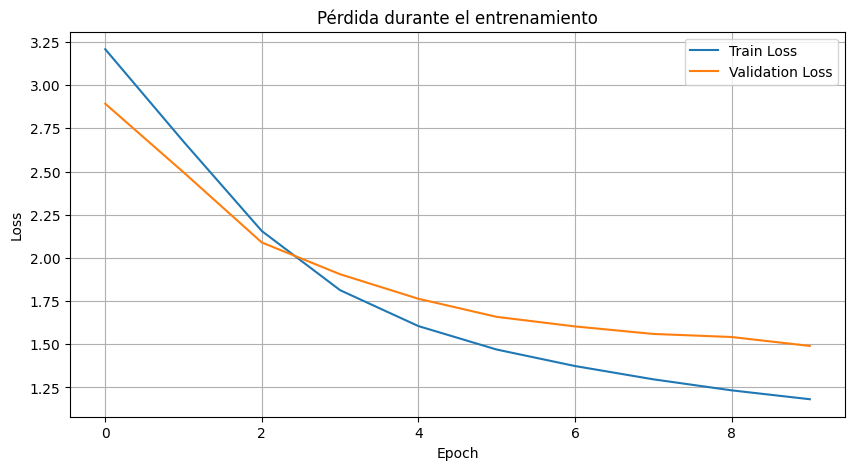

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
best_val = min(history['val_loss'])
best_epoch = history['val_loss'].index(best_val) + 1

print(f"Mejor pérdida de validación: {best_val:.4f} en la epoch {best_epoch}")
print(f"Última pérdida de entrenamiento: {history['train_loss'][-1]:.4f}")
print(f"Última pérdida de validación: {history['val_loss'][-1]:.4f}")


Mejor pérdida de validación: 1.4904 en la epoch 10
Última pérdida de entrenamiento: 1.1820
Última pérdida de validación: 1.4904


# Inferencia en el conjunto de test
Una muestra del test_loader, pasarla por el modelo y decodificar la salida a texto.

In [ ]:
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)
    pred_indices = pred_indices[:, 0].tolist()

    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)


model.load_state_dict(torch.load("asr_batch_model.pth"))
model.eval()

test_dataset = SpeechDataset(test_data, char_to_index)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

inputs, targets, input_lengths, target_lengths = next(iter(test_loader))
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(inputs)
    outputs = outputs.permute(1, 0, 2)  # (time, batch, classes)

# Decodificamos
pred_text = greedy_decoder(outputs, index_to_char)

# Texto original
original_text = "".join([index_to_char[i.item()] for i in targets if i.item() != 0])

print("\n Transcripción real:")
print(original_text)

print("\n Predicción del modelo:")
print(pred_text)



 Transcripción real:
AND MINE IS WILL STUTELEY SHALL WE BE COMRADES

 Predicción del modelo:
AND MIN IS MIS TULE SHAWY PBE COMRANS


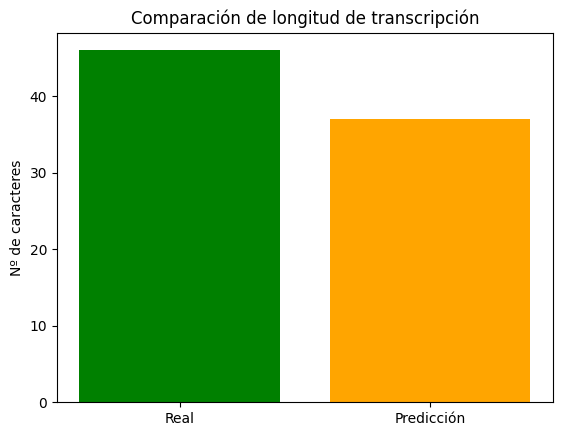

In [ ]:
plt.bar(["Real", "Predicción"], [len(original_text), len(pred_text)], color=["green", "orange"])
plt.title("Comparación de longitud de transcripción")
plt.ylabel("Nº de caracteres")
plt.show()


# RNN MEJORADO
Mejorar el modelo aumentando el batch size y la capacidad de las LSTM




In [ ]:
class SpeechToTextRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=29, num_layers=4):
        super(SpeechToTextRNN, self).__init__()
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=2)


In [ ]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
model = SpeechToTextRNN(input_dim=13, output_dim=len(char_to_index)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

num_epochs = 20
patience = 5
best_val_loss = float('inf')
patience_counter = 0

rnn_adv_train_losses = []
rnn_adv_val_losses = []

for epoch in range(num_epochs):
    train_loss = train_epoch(train_loader)
    val_loss = validate(valid_loader)

    rnn_adv_train_losses.append(train_loss)
    rnn_adv_val_losses.append(val_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "asr_best_model.pth")
        print(" Modelo mejorado guardado.")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping")
        break

print("Entrenamiento finalizado.")



Epoch [1/20] | Train Loss: 3.6026 | Val Loss: 2.9272
 Modelo mejorado guardado.
Epoch [2/20] | Train Loss: 2.8770 | Val Loss: 2.9272
 Modelo mejorado guardado.
Epoch [3/20] | Train Loss: 2.8770 | Val Loss: 2.9286
Epoch [4/20] | Train Loss: 2.8781 | Val Loss: 2.9277
Epoch [5/20] | Train Loss: 2.8773 | Val Loss: 2.9268
 Modelo mejorado guardado.
Epoch [6/20] | Train Loss: 2.8777 | Val Loss: 2.9263
 Modelo mejorado guardado.
Epoch [7/20] | Train Loss: 2.8762 | Val Loss: 2.9225
 Modelo mejorado guardado.
Epoch [8/20] | Train Loss: 2.8695 | Val Loss: 2.9127
 Modelo mejorado guardado.
Epoch [9/20] | Train Loss: 2.8626 | Val Loss: 2.9047
 Modelo mejorado guardado.
Epoch [10/20] | Train Loss: 2.8497 | Val Loss: 2.8847
 Modelo mejorado guardado.
Epoch [11/20] | Train Loss: 2.8235 | Val Loss: 2.8512
 Modelo mejorado guardado.
Epoch [12/20] | Train Loss: 2.7628 | Val Loss: 2.7480
 Modelo mejorado guardado.
Epoch [13/20] | Train Loss: 2.5875 | Val Loss: 2.5130
 Modelo mejorado guardado.
Epoch [14/

In [ ]:
# model.load_state_dict(torch.load("/content/asr_best_model.pth"))
# model.eval()


# Inferencia final con el modelo guardado
Vamos a probarlo ahora con el mejor modelo (asr_best_model.pth) en una muestra de test_loader.

In [ ]:
# Cargar modelo entrenado por no volver a ejecutar el codigo
model.load_state_dict(torch.load("asr_best_model.pth"))
model.eval()

test_dataset = SpeechDataset(test_data, char_to_index)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

# Obtener un batch
inputs, targets, input_lengths, target_lengths = next(iter(test_loader))
inputs = inputs.to(device)

with torch.no_grad():
    outputs = model(inputs)
    outputs = outputs.permute(1, 0, 2)  # (time, batch, classes)

# Decoder greedy
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[:, 0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)

# Texto predicho y real
pred_text = greedy_decoder(outputs, index_to_char)
true_text = "".join([index_to_char[i.item()] for i in targets if i.item() != 0])

print("\nTranscripción real:")
print(true_text)
print("\nPredicción del modelo:")
print(pred_text)



Transcripción real:
THE FARMER SAT GLOOMILY ON THE BENCH AND WOULD NOT EAT AND YOU CANNOT WONDER FOR HE SAW US PUTTING POTFULS OF HIS GOOD BEEF AND BASKET LOADS OF BREAD INTO OUR BIG MOUTHS

Predicción del modelo:
THE AERSED OMYM EBEG YO WE NOTY ANYONOUT ONER OR EOE POTING PIFUL OHIS GOD BE A BATEUEBRDEN DAR BE MO


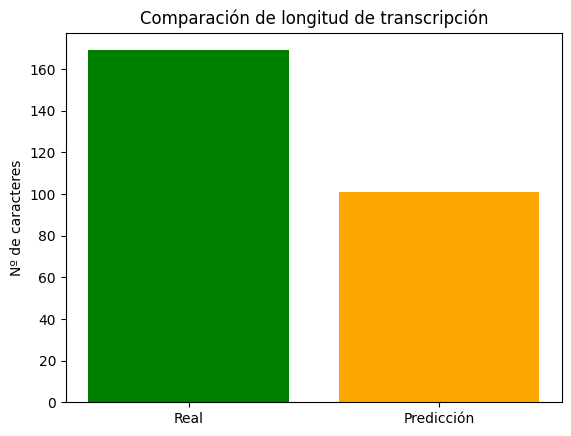

In [ ]:
plt.bar(["Real", "Predicción"], [len(true_text), len(pred_text)], color=["green", "orange"])
plt.title("Comparación de longitud de transcripción")
plt.ylabel("Nº de caracteres")
plt.show()

In [ ]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.4 MB/s eta 0:00:00


In [ ]:
rnn_simple = SpeechToTextRNN(input_dim=13, hidden_dim=128, output_dim=len(char_to_index), num_layers=2)
rnn_simple.load_state_dict(torch.load("/content/asr_batch_model.pth"))
rnn_simple.eval()

rnn_best = SpeechToTextRNN(input_dim=13, hidden_dim=256, output_dim=len(char_to_index), num_layers=4)
rnn_best.load_state_dict(torch.load("/content/asr_best_model.pth"))
rnn_best.eval()

SpeechToTextRNN(
  (lstm): LSTM(13, 256, num_layers=4, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=512, out_features=29, bias=True)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import gradio as gr
import torchaudio
import torch
import torchaudio.transforms as T


def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:  # 0 = <BLANK>
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)

import torchaudio.transforms as T

mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
)


def transcribe_rnn_demo(audio_path, model_name):
    waveform, sample_rate = torchaudio.load(audio_path)

    # 1. Convertir a mono si es estéreo
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # 2. Resamplear si no es 16kHz
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
        sample_rate = 16000

    # 3. Extraer MFCCs
    mfcc = mfcc_transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
    print("MFCC shape:", mfcc.shape)


    # 4. Elegir modelo
    if model_name == "RNN Simple":
        model = rnn_simple.to(device)
    elif model_name == "RNN Mejorado":
        model = rnn_best.to(device)
    else:
        return "Modelo no válido"


    model.eval()
    with torch.no_grad():
        output = model(mfcc).permute(1, 0, 2)  # (time, batch, classes)
        print("Output shape:", output.shape)
        pred_text = greedy_decoder(output, index_to_char)
        print("Texto predicho:", pred_text)



    transcription = greedy_decoder(output, index_to_char)
    return transcription


# Interfaz Gradio
demo = gr.Interface(
    fn=transcribe_rnn_demo,
    inputs=[
        gr.Audio(type="filepath", label="Sube tu archivo de audio (.wav)"),
        gr.Dropdown(choices=["RNN Simple", "RNN Mejorado"], label="--> Elige el modelo")
    ],
    outputs=gr.Textbox(label="Transcripción"),
    title="Demo de reconocimiento de voz con RNN",
    description="Sube un archivo de audio (WAV, 16kHz) y elige el modelo RNN para generar la transcripción automática."
)

demo.launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://51dce3600db62b9c05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


MFCC shape: torch.Size([1, 313, 13])
Output shape: torch.Size([313, 1, 29])
Texto predicho: 
MFCC shape: torch.Size([1, 313, 13])
Output shape: torch.Size([313, 1, 29])
Texto predicho: 
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://51dce3600db62b9c05.gradio.live


In [ ]:
import torchaudio

def transcribe_with_rnn(model, audio_path, mfcc_transform, device="cuda" if torch.cuda.is_available() else "cpu"):
    waveform, sample_rate = torchaudio.load(audio_path)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # MFCCs
    mfcc = mfcc_transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
    print("MFCC shape:", mfcc.shape)

    # Inferencia
    model.eval()
    with torch.no_grad():
        output = model(mfcc).permute(1, 0, 2)  # (time, batch, vocab)
        print("Output shape:", output.shape)

    # Decodificación greedy
    pred_indices = torch.argmax(output, dim=2)[:, 0].tolist()
    print("Predicted indices:", pred_indices)

    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx

    return "".join(pred_text)


# Fine-tuneado de Wav2Vec2 sobre nuestro dataset

 Convertir  dataset a datasets.Dataset


In [ ]:
import os
import csv

def generate_csv_from_librispeech(set_name, input_path, output_path):
    rows = []
    for speaker in os.listdir(input_path):
        speaker_path = os.path.join(input_path, speaker)
        if not os.path.isdir(speaker_path):
            continue
        for chapter in os.listdir(speaker_path):
            chapter_path = os.path.join(speaker_path, chapter)
            if not os.path.isdir(chapter_path):
                continue
            trans_file = os.path.join(chapter_path, f"{speaker}-{chapter}.trans.txt")
            if not os.path.exists(trans_file):
                continue
            with open(trans_file, "r") as f:
                transcriptions = {
                    line.split(" ")[0]: " ".join(line.strip().split(" ")[1:])
                    for line in f.readlines()
                }
            for file in os.listdir(chapter_path):
                if file.endswith(".flac"):
                    utt_id = file.replace(".flac", "")
                    audio_path = os.path.join(chapter_path, file)
                    if utt_id in transcriptions:
                        rows.append({
                            "path": audio_path,
                            "text": transcriptions[utt_id]
                        })

    # Guardar CSV
    csv_file = os.path.join(output_path, f"{set_name}.csv")
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.DictWriter(f, fieldnames=["path", "text"])
        writer.writeheader()
        writer.writerows(rows)

    print(f"CSV guardado: {csv_file} ({len(rows)} filas)")

# Ejecutamos para cada set
generate_csv_from_librispeech("train", "/content/LibriSpeech/LibriSpeech/train-clean-100", "/content")
generate_csv_from_librispeech("validation", "/content/LibriSpeech//LibriSpeech/dev-clean", "/content")
generate_csv_from_librispeech("test", "/content/LibriSpeech/LibriSpeech/test-clean", "/content")


CSV guardado: /content/train.csv (4178 filas)
CSV guardado: /content/validation.csv (2703 filas)
CSV guardado: /content/test.csv (2620 filas)


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which

In [ ]:
from datasets import load_dataset, Audio, DatasetDict

# Cargar desde CSV
dataset = DatasetDict({
    "train": load_dataset("csv", data_files="/content/train.csv", split="train"),
    "validation": load_dataset("csv", data_files="/content/validation.csv", split="train"),
    "test": load_dataset("csv", data_files="/content/test.csv", split="train")
})

# Convertir columna 'path' a audio real
dataset = dataset.cast_column("path", Audio(sampling_rate=16000))

# Verificamos
dataset


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'text'],
        num_rows: 4178
    })
    validation: Dataset({
        features: ['path', 'text'],
        num_rows: 2703
    })
    test: Dataset({
        features: ['path', 'text'],
        num_rows: 2620
    })
})

Preprocesamiento con Wav2Vec2Processor


path → input_values



In [ ]:
from transformers import Wav2Vec2Processor

# Cargamos el processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

def prepare_batch(batch):
    audio = batch["path"]
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["labels"] = processor.tokenizer(batch["text"]).input_ids
    return batch

dataset = dataset.map(prepare_batch, remove_columns=["path", "text"])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Map:   0%|          | 0/4178 [00:00<?, ? examples/s]

Map:   0%|          | 0/2703 [00:00<?, ? examples/s]

Map:   0%|          | 0/2620 [00:00<?, ? examples/s]

# Entrenamiento con Trainer


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import torch

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch["input_ids"] == self.processor.tokenizer.pad_token_id, -100)
        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2-librispeech",
    group_by_length=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    num_train_epochs=2, # sino tarda muchisimo
    fp16=torch.cuda.is_available(),
    learning_rate=1e-4,
    weight_decay=0.005,
    warmup_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="none"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Crear el Trainer y lanzar el entrenamiento



In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
model.to("cuda" if torch.cuda.is_available() else "cpu")


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
!pip install datasets evaluate
!pip install jiwer
pip install evaluate

In [ ]:
from evaluate import load

# métrica Word Error Rate
wer_metric = load("wer")

def compute_metrics(pred):
    import torch
    pred_ids = torch.argmax(torch.tensor(pred.predictions), dim=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)
    return {"wer": wer_metric.compute(predictions=pred_str, references=label_str)}

**NO COMPLAR  ESTOOOOO QUE TARDA COMO 2 HORAS**

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor.feature_extractor,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()


<ipython-input-49-ff83dd30984c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Wer
1,0.114900,0.080870,0.098654
2,0.080400,0.065922,0.088195


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in 

TrainOutput(global_step=1046, training_loss=0.0976374172115873, metrics={'train_runtime': 1604.0788, 'train_samples_per_second': 5.209, 'train_steps_per_second': 0.652, 'total_flos': 9.553258949758157e+17, 'train_loss': 0.0976374172115873, 'epoch': 2.0})

In [ ]:
trainer.save_model("wav2vec2-checkpoint")
processor.save_pretrained("wav2vec2-finetuned-librispeech")

[]

In [ ]:
preds = trainer.predict(dataset["test"])
test_wer = compute_metrics(preds)
print(f"WER en test: {test_wer['wer']:.4f}")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


WER en test: 0.0897


In [ ]:
import zipfile
import os
"""
# Lista de archivos ZIP y su ruta de destino
zip_files = {
    "/content/wav2vec2-checkpoint.zip": "/content/wav2vec2-checkpoint",
    "/content/wav2vec2-finetuned-librispeech.zip": "/content/wav2vec2-finetuned-librispeech"
}

for zip_path, extract_to in zip_files.items():
  #f zipfile.is_zipfile(zip_path):
       with zipfile.ZipFile(zip_path, 'r') as zip_ref:
           zip_ref.extractall(extract_to)
   else:
      print(f"{zip_path} no es un archivo zip válido.")
"""

'\n# Lista de archivos ZIP y su ruta de destino\nzip_files = {\n    "/content/wav2vec2-checkpoint.zip": "/content/wav2vec2-checkpoint",\n    "/content/wav2vec2-finetuned-librispeech.zip": "/content/wav2vec2-finetuned-librispeech"\n}\n\nfor zip_path, extract_to in zip_files.items():\n  #f zipfile.is_zipfile(zip_path):\n       with zipfile.ZipFile(zip_path, \'r\') as zip_ref:\n           zip_ref.extractall(extract_to)\n   else:\n      print(f"{zip_path} no es un archivo zip válido.")\n'

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch

# Cargar processor y modelo entrenado

processor = Wav2Vec2Processor.from_pretrained("/content/wav2vec2-finetuned-librispeech")
model = Wav2Vec2ForCTC.from_pretrained("/content/wav2vec2-checkpoint")
model.to("cuda" if torch.cuda.is_available() else "cpu")

print("Modelo Wav2Vec2 cargado correctamente")


Modelo Wav2Vec2 cargado correctamente


In [ ]:
from evaluate import load
import torch


"""
wer_metric = load("wer")

def compute_wer_on_dataset(dataset_split):
    predictions = []
    references = []

    for example in dataset_split:
        input_values = torch.tensor(example["input_values"]).unsqueeze(0).to(model.device)
        with torch.no_grad():
            logits = model(input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        pred_str = processor.batch_decode(pred_ids)[0]

        label_ids = example["labels"]
        label_ids = [id for id in label_ids if id != -100]
        label_str = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

        predictions.append(pred_str.lower())
        references.append(label_str.lower())

    return wer_metric.compute(predictions=predictions, references=references)
"""

'\nwer_metric = load("wer")\n\ndef compute_wer_on_dataset(dataset_split):\n    predictions = []\n    references = []\n\n    for example in dataset_split:\n        input_values = torch.tensor(example["input_values"]).unsqueeze(0).to(model.device)\n        with torch.no_grad():\n            logits = model(input_values).logits\n        pred_ids = torch.argmax(logits, dim=-1)\n        pred_str = processor.batch_decode(pred_ids)[0]\n\n        label_ids = example["labels"]\n        label_ids = [id for id in label_ids if id != -100]\n        label_str = processor.tokenizer.decode(label_ids, skip_special_tokens=True)\n\n        predictions.append(pred_str.lower())\n        references.append(label_str.lower())\n\n    return wer_metric.compute(predictions=predictions, references=references)\n'

In [ ]:
"""test_wer = compute_wer_on_dataset(dataset["test"])
print(f"WER en test: {test_wer:.4f}")
"""

'test_wer = compute_wer_on_dataset(dataset["test"])\nprint(f"WER en test: {test_wer:.4f}")\n'

In [ ]:
waveform, sample_rate, text = test_data[1]

def transcribe_audio(waveform, sample_rate=16000):
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values.to(model.device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription

# Transcripción real y predicha
print("\nTranscripción real:")
print(text)

predicted_text = transcribe_audio(waveform, sample_rate)
print("\nPredicción Wav2Vec2 fine-tuned:")
print(predicted_text)



Transcripción real:
IF THE WINE CHANGE INTO VINEGAR AND THE HOST CRUMBLE INTO CORRUPTION AFTER THEY HAVE BEEN CONSECRATED IS JESUS CHRIST STILL PRESENT UNDER THEIR SPECIES AS GOD AND AS MAN

Predicción Wav2Vec2 fine-tuned:
IF THE WINE CHANGE INTO VINEGAR AND THE HOST CRUMBLE INTO CORRUPTION AFTER THEY HAVE BEEN CONSECRATED IS JESUS CHRIST STILL PRESENT UNDER THEIR SPECIES AS GOD AND AS MAN


In [ ]:
waveform, sample_rate, text = test_data[2]

def transcribe_audio(waveform, sample_rate=16000):
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values.to(model.device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription

# Transcripción real y predicha
print("\nTranscripción real:")
print(text)

predicted_text = transcribe_audio(waveform, sample_rate)
print("\nPredicción Wav2Vec2 fine-tuned:")
print(predicted_text)



Transcripción real:
A GREAT SAINT SAINT FRANCIS XAVIER

Predicción Wav2Vec2 fine-tuned:
A GREAT SAINT SAINT FRANCES ZAVIER


# Evaluar en todo el test set



In [ ]:
from evaluate import load


wer_metric = load("wer")

# Predicción masiva
preds = trainer.predict(dataset["test"])
pred_ids = torch.argmax(torch.tensor(preds.predictions), dim=-1)
pred_texts = processor.batch_decode(pred_ids)
label_texts = processor.batch_decode(preds.label_ids, group_tokens=False)

wer_score = wer_metric.compute(predictions=pred_texts, references=label_texts)
print(f"WER en test: {wer_score:.4f}")


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


WER en test: 0.0895


In [ ]:
# Wav2Vec2 fine-tuned

from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("/content/wav2vec2-finetuned-librispeech")
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained("/content/wav2vec2-checkpoint")
wav2vec2_model.to(device)
wav2vec2_model.eval()



Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
from evaluate import load
wer_metric = load("wer")

def transcribe_rnn(model, dataset_idx):
    model = model.to(device)  # Mueve el modelo al mismo dispositivo que los datos que sino da error a veces
    mfcc, target = SpeechDataset(test_data, char_to_index)[dataset_idx]
    mfcc = mfcc.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(mfcc).permute(1, 0, 2)
    pred_text = greedy_decoder(output, index_to_char)
    true_text = "".join([index_to_char[i.item()] for i in target if i.item() != 0])
    wer = wer_metric.compute(predictions=[pred_text], references=[true_text])
    return pred_text, true_text, wer


def transcribe_wav2vec2(waveform, sample_rate, true_text):
    if sample_rate != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values.to(device)
    with torch.no_grad():
        logits = wav2vec2_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    pred_text = processor.batch_decode(predicted_ids)[0]
    wer = wer_metric.compute(predictions=[pred_text], references=[true_text])
    return pred_text, wer


In [ ]:
from transformers import Wav2Vec2ForCTC

wav2vec2_model = Wav2Vec2ForCTC.from_pretrained(
    "/content/wav2vec2-checkpoint",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
wav2vec2_model.to(device)
wav2vec2_model.eval()


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

In [ ]:
import random

# Seleccionamos una muestra aleatoria
sample_idx = random.randint(0, len(test_data)-1)
waveform, sample_rate, true_text = test_data[sample_idx]

# --- RNN simple ---
rnn_pred_1, _, wer_rnn_simple = transcribe_rnn(rnn_simple, sample_idx)

# --- RNN mejorado ---
rnn_pred_2, true_text, wer_rnn_best = transcribe_rnn(rnn_best, sample_idx)

# --- Wav2Vec2 ---
wav2vec2_pred, wer_wav2vec2 = transcribe_wav2vec2(waveform, sample_rate, true_text)

# Mostrar resultados
print(f"Muestra {sample_idx}")
print("Texto real:")
print(true_text)
print("\nRNN Simple:\n", rnn_pred_1, f"\nWER: {wer_rnn_simple:.3f}")
print("\nRNN Mejorado:\n", rnn_pred_2, f"\nWER: {wer_rnn_best:.3f}")
print("\nWav2Vec2 Fine-tuned:\n", wav2vec2_pred, f"\nWER: {wer_wav2vec2:.3f}")


Muestra 2619
Texto real:
YES THE CHARACTER WHICH YOUR ROYAL HIGHNESS ASSUMED IS IN PERFECT HARMONY WITH YOUR OWN

RNN Simple:
  
WER: 1.000

RNN Mejorado:
  
WER: 1.000

Wav2Vec2 Fine-tuned:
 YES THE CHARACTER WHICH YOUR ROYAL HIGHNESS ASSUMED IS IN PERFECT HARMONY WITH YOUR OWN 
WER: 0.000


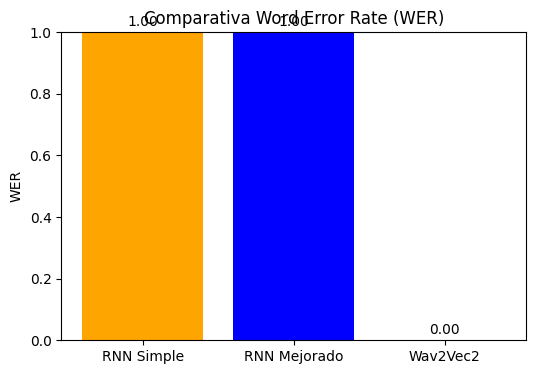

In [ ]:
import matplotlib.pyplot as plt

model_names = ["RNN Simple", "RNN Mejorado", "Wav2Vec2"]
wer_scores = [wer_rnn_simple, wer_rnn_best, wer_wav2vec2]

plt.figure(figsize=(6, 4))
plt.bar(model_names, wer_scores, color=["orange", "blue", "green"])
plt.title("Comparativa Word Error Rate (WER)")
plt.ylabel("WER")
plt.ylim(0, 1)
for i, val in enumerate(wer_scores):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
plt.show()


In [ ]:
# muestra de test
inputs, targets, input_lengths, target_lengths = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

# Salidas RNN Simple
output_rnn_simple = rnn_simple(inputs).permute(1, 0, 2)

# Salidas RNN Mejorado
output_rnn_adv = rnn_best(inputs).permute(1, 0, 2)


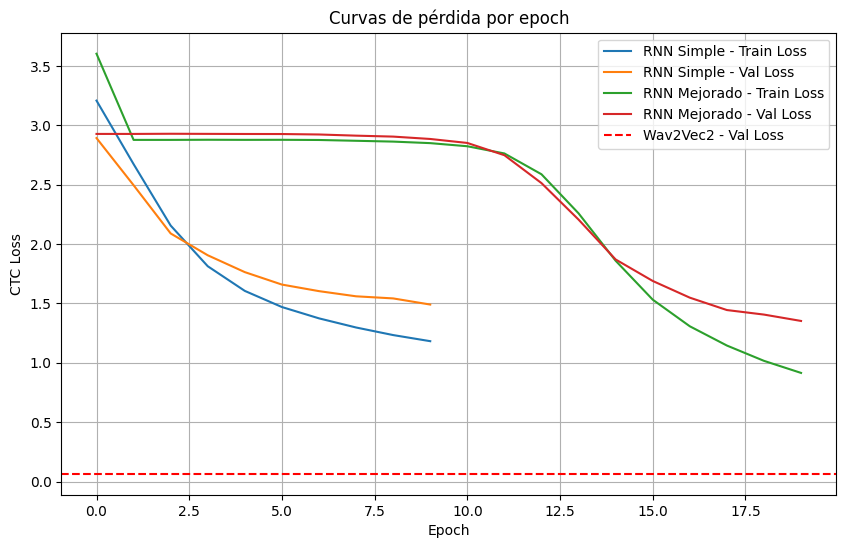

In [ ]:
import matplotlib.pyplot as plt

#  Curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(rnn_simple_train_losses, label="RNN Simple - Train Loss")
plt.plot(rnn_simple_val_losses, label="RNN Simple - Val Loss")
plt.plot(rnn_adv_train_losses, label="RNN Mejorado - Train Loss")
plt.plot(rnn_adv_val_losses, label="RNN Mejorado - Val Loss")

# Wav2Vec2 último eval_loss
if hasattr(trainer.state, "log_history"):
    wav2vec2_val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    if wav2vec2_val_losses:
        plt.axhline(y=min(wav2vec2_val_losses), linestyle='--', color='red', label="Wav2Vec2 - Val Loss")

plt.title("Curvas de pérdida por epoch")
plt.xlabel("Epoch")
plt.ylabel("CTC Loss")
plt.grid(True)
plt.legend()
plt.show()




In [ ]:
from google.colab import files
files.download('/content/wav2vec2-librispeech')
files.download('/content/wav2vec2-finetuned-librispeech')
files.download('/content/wav2vec2-checkpoint')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Obtener un batch del test loader
inputs, targets, input_lengths, target_lengths = next(iter(test_loader))
inputs = inputs.to(device)
targets = targets.to(device)

# --- RNN Simple ---
rnn_simple.eval()
with torch.no_grad():
    raw_output_rnn_simple = rnn_simple(inputs)

output_rnn_simple = raw_output_rnn_simple.permute(1, 0, 2)  # (time, batch, classes)
pred_text_rnn_simple = greedy_decoder(output_rnn_simple, index_to_char)
true_text = "".join([index_to_char[i.item()] for i in targets if i.item() != 0])

wer_rnn_simple = wer_metric.compute(predictions=[pred_text_rnn_simple], references=[true_text])

# --- RNN Mejorado ---
rnn_best.eval()
with torch.no_grad():
    raw_output_rnn_adv = rnn_best(inputs)

output_rnn_adv = raw_output_rnn_adv.permute(1, 0, 2)
pred_text_rnn_adv = greedy_decoder(output_rnn_adv, index_to_char)

wer_rnn_adv = wer_metric.compute(predictions=[pred_text_rnn_adv], references=[true_text])


In [ ]:
wer_values = [wer_rnn_simple, wer_rnn_adv, wer_score]


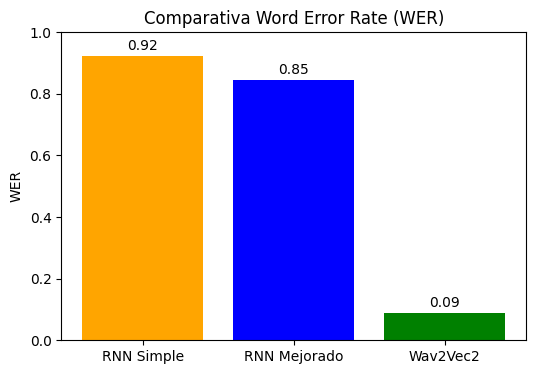

In [ ]:
# Decodificación de predicciones
output_rnn_simple = raw_output_rnn_simple.permute(1, 0, 2)
output_rnn_adv = raw_output_rnn_adv.permute(1, 0, 2)

# Greedy decoding
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[:, 0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)

# Predicciones
pred_text_rnn_simple = greedy_decoder(output_rnn_simple, index_to_char)
pred_text_rnn_adv = greedy_decoder(output_rnn_adv, index_to_char)
true_text = "".join([index_to_char[i.item()] for i in targets if i.item() != 0])

# Calcular WERs
wer_rnn_simple = wer_metric.compute(predictions=[pred_text_rnn_simple], references=[true_text])
wer_rnn_adv = wer_metric.compute(predictions=[pred_text_rnn_adv], references=[true_text])

# Juntar con wav2vec2
wer_values = [wer_rnn_simple, wer_rnn_adv, wer_score]



model_names = ["RNN Simple", "RNN Mejorado", "Wav2Vec2"]

plt.figure(figsize=(6, 4))
plt.bar(model_names, wer_values, color=["orange", "blue", "green"])
plt.title("Comparativa Word Error Rate (WER)")
plt.ylabel("WER")
plt.ylim(0, 1)
for i, val in enumerate(wer_values):
    plt.text(i, val + 0.02, f"{val:.2f}", ha='center')
plt.show()


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
import gradio as gr
import torchaudio
import torch

In [ ]:

def transcribe_from_file(audio_file):
    # Cargar audio
    waveform, sample_rate = torchaudio.load(audio_file)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # Procesar audio
    input_values = processor(
        waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000
    ).input_values.to(model.device)

    # Inferencia
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription

# Gradio
demo = gr.Interface(
    fn=transcribe_from_file,
    inputs=gr.Audio(type="filepath", label="Sube tu archivo de audio (.wav)"),
    outputs=gr.Textbox(label="Transcripción"),
    title="Demo ASR con Wav2Vec2",
    description="Sube un audio (formato WAV) y este modelo lo transcribirá automáticamente.",
)

demo.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://27a47cb159a45fd2da.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://27a47cb159a45fd2da.gradio.live


# CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch
import torchaudio
from evaluate import load

class CNN_ASR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN_ASR, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, stride=2, padding=1),  # Conv1
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),         # Conv2
            nn.ReLU(),
            nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1),         # Conv3
            nn.ReLU()
        )

        self.classifier = nn.Linear(256, output_dim)  # Final dense capa

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, time, features) → (batch, features, time)
        x = self.conv(x)
        x = x.transpose(1, 2)  # (batch, time, features) otra vez
        x = self.classifier(x)
        return F.log_softmax(x, dim=2)

    def get_output_lengths(self, input_lengths):
        for _ in range(3):
            input_lengths = ((input_lengths + 1) // 2)
        return input_lengths


In [ ]:
cnn_model = CNN_ASR(input_dim=13, output_dim=len(char_to_index)).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)


# Funciones de entrenamiento y validación (para CNN + CTC):





In [ ]:
def train_epoch(loader):
    cnn_model.train()
    total_loss = 0
    for inputs, targets, input_lengths, target_lengths in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        outputs = outputs.permute(1, 0, 2)

        output_lengths = cnn_model.get_output_lengths(input_lengths)

        loss = ctc_loss(outputs, targets, output_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def validate(loader):
    cnn_model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets, input_lengths, target_lengths in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = cnn_model(inputs).permute(1, 0, 2)
            output_lengths = cnn_model.get_output_lengths(input_lengths)

            loss = ctc_loss(outputs, targets, output_lengths, target_lengths)
            total_loss += loss.item()
    return total_loss / len(loader)


In [ ]:
cnn_train_losses = []
cnn_val_losses = []

for epoch in range(10):
    train_loss = train_epoch(train_loader)
    val_loss = validate(valid_loader)

    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")


Epoch 1: Train Loss = 0.5301 | Val Loss = 0.6621
Epoch 2: Train Loss = 0.5078 | Val Loss = 0.6573
Epoch 3: Train Loss = 0.5152 | Val Loss = 0.6557
Epoch 4: Train Loss = 0.5088 | Val Loss = 0.6575
Epoch 5: Train Loss = 0.5057 | Val Loss = 0.6607
Epoch 6: Train Loss = 0.5028 | Val Loss = 0.6535
Epoch 7: Train Loss = 0.5043 | Val Loss = 0.6545
Epoch 8: Train Loss = 0.5015 | Val Loss = 0.6539
Epoch 9: Train Loss = 0.4966 | Val Loss = 0.6563
Epoch 10: Train Loss = 0.4891 | Val Loss = 0.6586


In [ ]:
torch.save(cnn_model.state_dict(), "cnn_asr_model.pth")
print("Modelo CNN guardado.")

Modelo CNN guardado.


Texto real:
LOVE IS A BABE THEN MIGHT I NOT SAY SO TO GIVE FULL GROWTH TO THAT WHICH STILL DOTH GROW

Predicción CNN:
<UNK>

WER (CNN): 1.0000


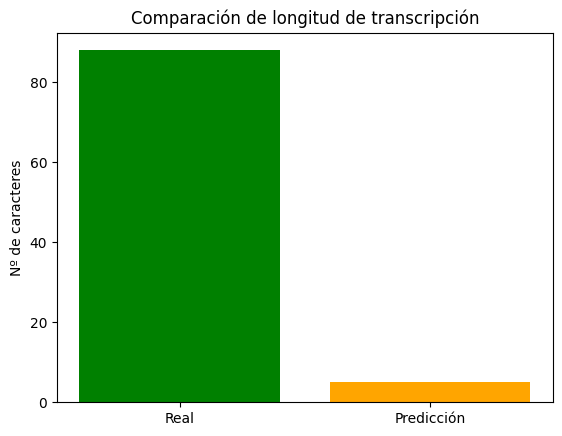

In [ ]:

wer_metric = load("wer")

# Greedy decoder (CTC)
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[0].tolist()  # (time,)
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:  # ignorar BLANK
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)


# Sample aleatorio del dataset
sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]


# Convertir a MFCC
transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
)
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)  # (1, time, 13)


# Inference con CNN
cnn_model.eval()
with torch.no_grad():
    output = cnn_model(mfcc).permute(1, 0, 2)  # (time, batch, classes)


# Decodificar predicción
pred_text = greedy_decoder(output, index_to_char)


# Texto real
true_text_clean = "".join([c for c in true_text if c in char_to_index])


# Calcular WER
wer_cnn = wer_metric.compute(predictions=[pred_text.lower()], references=[true_text_clean.lower()])


# resultados
print("Texto real:")
print(true_text_clean)
print("\nPredicción CNN:")
print(pred_text)
print(f"\nWER (CNN): {wer_cnn:.4f}")

# longitudes
plt.bar(["Real", "Predicción"], [len(true_text_clean), len(pred_text)], color=["green", "orange"])
plt.title("Comparación de longitud de transcripción")
plt.ylabel("Nº de caracteres")
plt.show()


fatality

# Mejorar el modelo CNN


Modelo CNN_ASR mejorado con :

- Dropout
- BatchNorm
- Más capas convolucionales
- Activaciones ReLU


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ASR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN_ASR, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 128, kernel_size=3, stride=1, padding=1),  # Conv1
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1),        # Conv2
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1),        # Conv3
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Conv1d(256, 256, kernel_size=3, stride=2, padding=1),        # Conv4
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.classifier = nn.Linear(256, output_dim)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv(x)
        x = x.transpose(1, 2)
        x = self.classifier(x)          # capa final lineal
        return F.log_softmax(x, dim=2)  # output para CTC Loss

    def get_output_lengths(self, input_lengths):
        for _ in range(3):
            input_lengths = ((input_lengths + 1) // 2)
        return input_lengths


In [ ]:
cnn_model = CNN_ASR(input_dim=13, output_dim=len(char_to_index)).to(device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)


In [ ]:
cnn_train_losses = []
cnn_val_losses = []

for epoch in range(30):
    train_loss = train_epoch(train_loader)
    val_loss = validate(valid_loader)

    cnn_train_losses.append(train_loss)
    cnn_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")


Epoch 1: Train Loss = 0.4526 | Val Loss = 0.4629
Epoch 2: Train Loss = 0.4436 | Val Loss = 0.4605
Epoch 3: Train Loss = 0.4419 | Val Loss = 0.4619
Epoch 4: Train Loss = 0.4419 | Val Loss = 0.4570
Epoch 5: Train Loss = 0.4392 | Val Loss = 0.4561
Epoch 6: Train Loss = 0.4373 | Val Loss = 0.4577
Epoch 7: Train Loss = 0.4380 | Val Loss = 0.4578
Epoch 8: Train Loss = 0.4343 | Val Loss = 0.4559
Epoch 9: Train Loss = 0.4328 | Val Loss = 0.4554
Epoch 10: Train Loss = 0.4346 | Val Loss = 0.4580
Epoch 11: Train Loss = 0.4300 | Val Loss = 0.4574
Epoch 12: Train Loss = 0.4253 | Val Loss = 0.4565
Epoch 13: Train Loss = 0.4222 | Val Loss = 0.4613
Epoch 14: Train Loss = 0.4186 | Val Loss = 0.4590
Epoch 15: Train Loss = 0.4150 | Val Loss = 0.4561
Epoch 16: Train Loss = 0.4106 | Val Loss = 0.4603
Epoch 17: Train Loss = 0.4066 | Val Loss = 0.4600
Epoch 18: Train Loss = 0.4046 | Val Loss = 0.4647
Epoch 19: Train Loss = 0.4018 | Val Loss = 0.4664
Epoch 20: Train Loss = 0.3944 | Val Loss = 0.4614
Epoch 21:

In [ ]:
torch.save(cnn_model.state_dict(), "cnn_asr_improved.pth")


# Evaluar en el test set


In [ ]:
cnn_model.eval()
with torch.no_grad():
    output = cnn_model(mfcc).permute(1, 0, 2)

pred_text = greedy_decoder(output, index_to_char)

wer = wer_metric.compute(predictions=[pred_text.lower()], references=[true_text.lower()])


In [ ]:
import random
from torchaudio.transforms import MFCC

#  muestra aleatoria del test set
sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]

# Convertir a MFCC
transform = MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
)
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)


In [ ]:
cnn_model.eval()
with torch.no_grad():
    output = cnn_model(mfcc).permute(1, 0, 2)  # (time, batch, vocab)


In [ ]:
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)

pred_text = greedy_decoder(output, index_to_char)


In [ ]:
cnn_model.load_state_dict(torch.load("cnn_asr_improved.pth"))
cnn_model.eval()


CNN_ASR(
  (conv): Sequential(
    (0): Conv1d(13, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(256, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(256, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (13): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.1, inplace=False)
  )
  (classifier): Linear(in_features=256, out_features=32, bias=True)
)

🎙️ Texto real:
VENICE

🧠 Texto predicho (CNN):
 

📏 WER: 1.0000


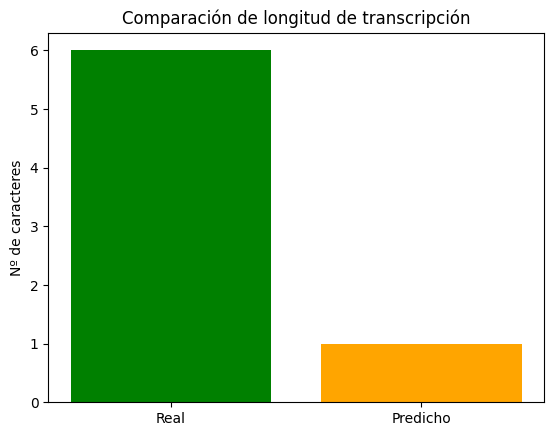

Indices predichos: [4]


In [ ]:
import random
import torchaudio
import torch
import matplotlib.pyplot as plt
from evaluate import load

wer_metric = load("wer")

sample_idx = random.randint(0, len(test_data) - 1)
waveform, sample_rate, true_text = test_data[sample_idx]

transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
)
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)
mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-5)


#  Predicción
cnn_model.eval()
with torch.no_grad():
    output = cnn_model(mfcc).permute(1, 0, 2)  # (time, batch, vocab)

# Greedy decoder (CTC)
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:  # 0 = <BLANK>
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)

pred_text = greedy_decoder(output, index_to_char)

true_text_clean = "".join([c for c in true_text if c in char_to_index])

# Calcular WER
wer = wer_metric.compute(predictions=[pred_text.lower()], references=[true_text_clean.lower()])

print("🎙️ Texto real:")
print(true_text_clean)

print("\nTexto predicho (CNN):")
print(pred_text)

print(f"\nWER: {wer:.4f}")

# longitud
plt.bar(["Real", "Predicho"], [len(true_text_clean), len(pred_text)], color=["green", "orange"])
plt.title("Comparación de longitud de transcripción")
plt.ylabel("Nº de caracteres")
plt.show()
print("Indices predichos:", torch.argmax(output, dim=2)[0][:50].tolist())


In [ ]:
with torch.no_grad():
    output = cnn_model(mfcc).permute(1, 0, 2)
    print("Logits promedio (por clase):", output.mean(dim=[0, 1]))


Logits promedio (por clase): tensor([ -4.0324, -18.4268,  -4.9425, -24.0010,  -0.6828, -11.3168,  -3.9675,
         -7.0404,  -5.3091,  -5.1422,  -3.5777,  -4.8770,  -4.9469,  -2.0277,
         -2.5708, -14.5284,  -6.6540,  -5.8470,  -5.5461,  -3.6222,  -3.5249,
         -5.9549, -12.2530,  -4.9314,  -3.4557,  -3.5568,  -3.9798,  -8.1676,
         -6.0149, -10.7996,  -5.8822,  -9.9972], device='cuda:0')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Wav2LetterCNN(nn.Module):
    def __init__(self, input_dim=40, num_classes=32):
        super(Wav2LetterCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(input_dim, 250, kernel_size=48, stride=2, padding=24),
            nn.BatchNorm1d(250),
            nn.GELU(),

            *[
                nn.Sequential(
                    nn.Conv1d(250, 250, kernel_size=7, stride=1, padding=3),
                    nn.BatchNorm1d(250),
                    nn.GELU()
                ) for _ in range(7)
            ],

            nn.Conv1d(250, 512, kernel_size=32, stride=1, padding=16),
            nn.BatchNorm1d(512),
            nn.GELU(),

            nn.Conv1d(512, 512, kernel_size=1),
            nn.BatchNorm1d(512),
            nn.GELU(),

            nn.Conv1d(512, num_classes, kernel_size=1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.conv_layers(x)
        x = x.transpose(1, 2)
        return F.log_softmax(x, dim=2)

    def get_output_lengths(self, input_lengths):
        return (input_lengths + 1) // 2


In [ ]:
model = Wav2LetterCNN(input_dim=40, num_classes=len(char_to_index)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)


In [ ]:
# Funciones de entrenamiento
def train_epoch(loader):
    model.train()
    total_loss = 0
    for inputs, targets, input_lengths, target_lengths in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.permute(1, 0, 2)

        output_lengths = model.get_output_lengths(input_lengths)
        loss = ctc_loss(outputs, targets, output_lengths, target_lengths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

def validate(loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets, input_lengths, target_lengths in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).permute(1, 0, 2)
            output_lengths = model.get_output_lengths(input_lengths)
            loss = ctc_loss(outputs, targets, output_lengths, target_lengths)
            total_loss += loss.item()
    return total_loss / len(loader)


In [ ]:
import torchaudio
from torchaudio.transforms import MFCC

mfcc_transform = MFCC(
    sample_rate=16000,
    n_mfcc=40,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)

import torch
from torch.utils.data import Dataset

class SpeechDataset(Dataset):
    def __init__(self, data, transform, char_to_index):
        self.data = data
        self.transform = transform
        self.char_to_index = char_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        waveform, sample_rate, transcript = self.data[idx]

        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0, keepdim=True)
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        mfcc = self.transform(waveform).squeeze(0).transpose(0, 1)  # (time, n_mfcc)
        target = [self.char_to_index[c] for c in transcript.upper() if c in self.char_to_index]

        return mfcc, torch.tensor(target, dtype=torch.long), mfcc.shape[0], len(target)




In [ ]:
def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    mfccs, targets, input_lengths, target_lengths = zip(*batch)

    mfccs_padded = nn.utils.rnn.pad_sequence(mfccs, batch_first=True)
    targets_concat = torch.cat(targets)

    return mfccs_padded, targets_concat, torch.tensor(input_lengths), torch.tensor(target_lengths)


In [ ]:
# Dataset y DataLoaders
train_dataset = SpeechDataset(train_data, mfcc_transform, char_to_index)
valid_dataset = SpeechDataset(valid_data, mfcc_transform, char_to_index)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [ ]:
# Entrenamiento
train_losses, val_losses = [], []
for epoch in range(15):
    train_loss = train_epoch(train_loader)
    val_loss = validate(valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f} | Val Loss = {val_loss:.4f}")


Epoch 1: Train Loss = 2.8030 | Val Loss = 2.6394
Epoch 2: Train Loss = 2.5285 | Val Loss = 2.5291
Epoch 3: Train Loss = 2.2000 | Val Loss = 2.0837
Epoch 4: Train Loss = 1.6343 | Val Loss = 1.6564
Epoch 5: Train Loss = 1.2667 | Val Loss = 1.4567
Epoch 6: Train Loss = 1.0297 | Val Loss = 1.3362
Epoch 7: Train Loss = 0.8572 | Val Loss = 1.2165
Epoch 8: Train Loss = 0.7173 | Val Loss = 1.1886
Epoch 9: Train Loss = 0.5943 | Val Loss = 1.1116
Epoch 10: Train Loss = 0.4935 | Val Loss = 1.1243
Epoch 11: Train Loss = 0.4041 | Val Loss = 1.1698
Epoch 12: Train Loss = 0.3332 | Val Loss = 1.1950
Epoch 13: Train Loss = 0.2619 | Val Loss = 1.3663
Epoch 14: Train Loss = 0.2114 | Val Loss = 1.3348
Epoch 15: Train Loss = 0.1731 | Val Loss = 1.4711


In [ ]:

# Guardar modelo
torch.save(model.state_dict(), "wav2letter_cnn_model.pth")
print("Modelo Wav2Letter guardado.")


Modelo Wav2Letter guardado.


# 1. Cargar modelo y definir decoder


In [ ]:
import torch
from evaluate import load

# Cargar el modelo entrenado
wav2letter_model = Wav2LetterCNN(input_dim=40, num_classes=len(char_to_index)).to(device)
wav2letter_model.load_state_dict(torch.load("wav2letter_cnn_model.pth"))
wav2letter_model.eval()

wer_metric = load("wer")

# Decoder CTC greedy
def greedy_decoder(output, index_to_char):
    pred_indices = torch.argmax(output, dim=2)[:, 0].tolist()
    pred_text = []
    prev_idx = None
    for idx in pred_indices:
        if idx != prev_idx and idx != 0:  # 0 = <BLANK>
            pred_text.append(index_to_char.get(idx, ""))
        prev_idx = idx
    return "".join(pred_text)


# 2. Seleccionar muestra del test set y preparar MFCCs



In [ ]:
import random
import torchaudio

# muestra aleatoria
sample_idx = random.randint(0, len(test_data)-1)
waveform, sample_rate, true_text = test_data[sample_idx]

# mono y 16kHz
if waveform.shape[0] > 1:
    waveform = waveform.mean(dim=0, keepdim=True)
if sample_rate != 16000:
    waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

# Convertir a MFCCs
transform = torchaudio.transforms.MFCC(
    sample_rate=16000,
    n_mfcc=40,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
)
mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)


# 3. Inferencia + evaluación


In [ ]:
with torch.no_grad():
    output = wav2letter_model(mfcc).permute(1, 0, 2)

# Decodificar predicción
pred_text = greedy_decoder(output, index_to_char)

# Limpiar texto real
true_text_clean = "".join([c for c in true_text if c in char_to_index])

# Calcular WER
wer_wav2letter = wer_metric.compute(predictions=[pred_text.lower()], references=[true_text_clean.lower()])

print("Texto real:")
print(true_text_clean)

print("\nPredicción (Wav2Letter CNN):")
print(pred_text)

print(f"\nWER: {wer_wav2letter:.4f}")



Texto real:
HAM TO BE OR NOT TO BE

Predicción (Wav2Letter CNN):
AM TO BE OR NOT TO BE

WER: 0.1429


In [ ]:
import gradio as gr
import torchaudio
import torch

def transcribe_with_wav2letter(audio_path):
    waveform, sr = torchaudio.load(audio_path)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(sr, 16000)(waveform)

    transform = torchaudio.transforms.MFCC(
        sample_rate=16000,
        n_mfcc=40,
        melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 40}
    )
    mfcc = transform(waveform).squeeze(0).transpose(0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        output = wav2letter_model(mfcc).permute(1, 0, 2)
    pred_text = greedy_decoder(output, index_to_char)
    return pred_text

# Gradio
gr.Interface(
    fn=transcribe_with_wav2letter,
    inputs=gr.Audio(label="Sube tu audio WAV", type="filepath"),
    outputs=gr.Textbox(label="Transcripción"),
    title="Reconocimiento de Voz - Wav2LetterCNN",
    description="Demo de transcripción de audio usando CNN con CTC (modelo Wav2Letter)."
).launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://10f9fc40a84759d960.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://10f9fc40a84759d960.gradio.live


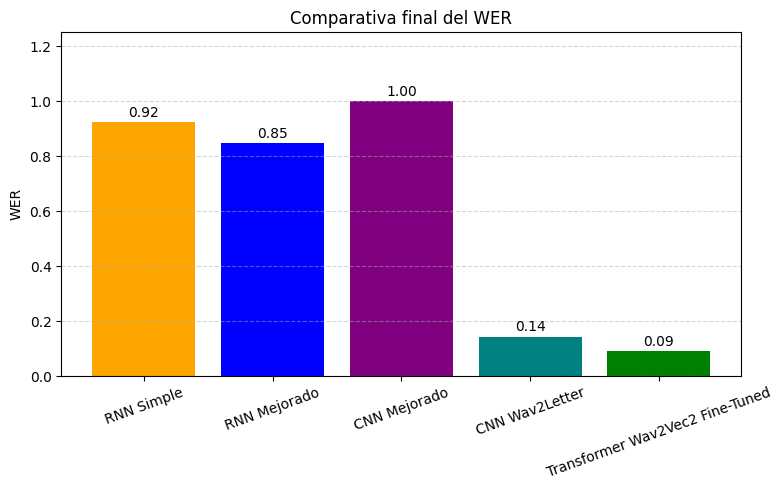

In [ ]:
import matplotlib.pyplot as plt

wer_values = [wer_rnn_simple, wer_rnn_adv, wer_cnn, wer_wav2letter, wer_score]
model_names = ["RNN Simple", "RNN Mejorado", "CNN Mejorado", "CNN Wav2Letter", "Transformer Wav2Vec2 Fine-Tuned"]

colors = ["orange", "blue", "purple", "teal", "green"]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, wer_values, color=colors)
plt.title("Comparativa final del WER")
plt.ylabel("WER")
plt.ylim(0, 1.25)

for bar, value in zip(bars, wer_values):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.02, f"{value:.2f}", ha='center', fontsize=10)

plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


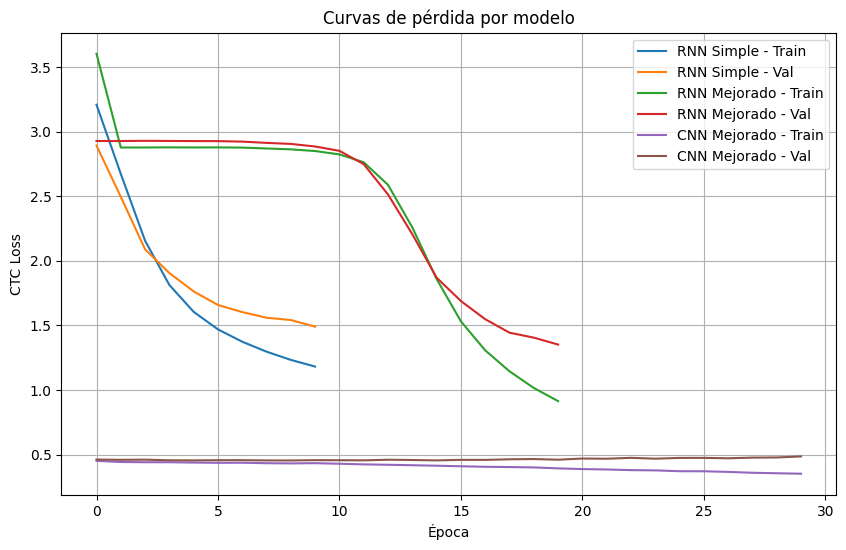

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rnn_simple_train_losses, label="RNN Simple - Train")
plt.plot(rnn_simple_val_losses, label="RNN Simple - Val")
plt.plot(rnn_adv_train_losses, label="RNN Mejorado - Train")
plt.plot(rnn_adv_val_losses, label="RNN Mejorado - Val")
plt.plot(cnn_train_losses, label="CNN Mejorado - Train")
plt.plot(cnn_val_losses, label="CNN Mejorado - Val")
plt.xlabel("Época")
plt.ylabel("CTC Loss")
plt.title("Curvas de pérdida por modelo")
plt.legend()
plt.grid(True)
plt.show()


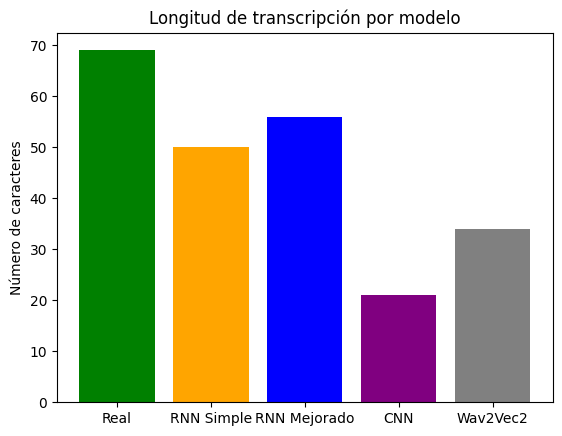

In [ ]:
model_names = ["Real", "RNN Simple", "RNN Mejorado", "CNN", "Wav2Vec2"]
lengths = [len(true_text), len(pred_text_rnn_simple), len(pred_text_rnn_adv), len(pred_text), len(predicted_text)]

plt.bar(model_names, lengths, color=["green", "orange", "blue", "purple", "gray"])
plt.title("Longitud de transcripción por modelo")
plt.ylabel("Número de caracteres")
plt.show()


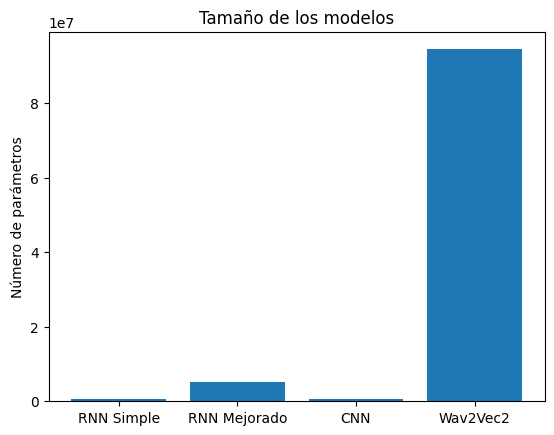

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

sizes = [
    count_parameters(rnn_simple),
    count_parameters(rnn_best),
    count_parameters(cnn_model),
    count_parameters(wav2vec2_model)
]

plt.bar(["RNN Simple", "RNN Mejorado", "CNN", "Wav2Vec2"], sizes)
plt.ylabel("Número de parámetros")
plt.title("Tamaño de los modelos")
plt.show()
